In [1]:
from openai import OpenAI
from pydantic import BaseModel
from typing import Dict, List,Tuple,Optional
from dotenv import load_dotenv
from utils import *
from chatty_boi import *
import os
from tqdm import tqdm
import pandas as pd
import pickle
import glob2


In [2]:
with open("./prompt_lib/base_prompt.txt", "r") as f:
    prompt = f.read()

with open("./prompt_lib/constraint_prompt.txt", "r") as f:
    constraints_prompt = f.read()

with open("./prompt_lib/optimize_prompt.txt", "r") as f:
    optimize_prompt = f.read()

input_data = {}
with open("./prompt_lib/base_inputs.txt", "r") as f:
    exec(f.read(),{}, input_data)


base_prompt = prompt
constraints_prompt = constraints_prompt
optimize_prompt = optimize_prompt

node_dict_input = input_data["node_dict_input"]
example_members_input = input_data["example_members_input"]
area_id = input_data["area_id"]
load = input_data["load"]
supports = input_data["supports"]
area_id


{'0': 1,
 '1': 0.195,
 '2': 0.782,
 '3': 1.759,
 '4': 3.128,
 '5': 4.887,
 '6': 7.037,
 '7': 9.578,
 '8': 12.511,
 '9': 15.834,
 '10': 19.548}

In [3]:
df_q1 = pd.read_pickle("./results_final_runs/final_df_q1.pkl")
df_q1

,task,variation,max_stress,max_weight,model,temp,run_id,total_steps,total_attempts,best_structure,best_result,best_max_stress,best_total_mass,best_max_stress_to_weight_ratio,success,best_node,best_member
0,1,1,15,30,gpt,0.5,0,2,3,<truss_y.Truss object at 0x7f56c8926cf0>,"{'max_stress_to_weight_ratio': 0.3702, 'total_...",9.8521,26.6143,0.3702,True,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_2', '0'], 'membe..."
1,1,1,15,30,gpt,0.5,1,2,2,<truss_y.Truss object at 0x7f570550e990>,"{'max_stress_to_weight_ratio': 0.1898, 'total_...",5.5513,29.2425,0.1898,True,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_3', '3'], 'membe..."
2,1,1,15,30,gpt,0.5,2,4,5,<truss_y.Truss object at 0x7f570550e5d0>,"{'max_stress_to_weight_ratio': 0.328, 'total_m...",8.3888,25.5778,0.328,True,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_3', '3'], 'membe..."
3,1,1,15,30,gpt,0.5,3,3,3,<truss_y.Truss object at 0x7f5705564770>,"{'max_stress_to_weight_ratio': 0.3527, 'total_...",10.5293,29.8522,0.3527,True,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_2', '2'], 'membe..."
4,1,1,15,30,gpt,0.5,4,9,9,<truss_y.Truss object at 0x7f5705564b00>,"{'max_stress_to_weight_ratio': 0.3825, 'total_...",8.1413,21.2828,0.3825,True,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_3', '3'], 'membe..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1,3,30,30,mini,1.2,5,10,17,<truss_y.Truss object at 0x7f56c84e1bf0>,"{'max_stress_to_weight_ratio': 0.6021, 'total_...",13.722,22.7884,0.6021,True,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_4', '2'], 'membe..."
176,1,3,30,30,mini,1.2,6,6,7,<truss_y.Truss object at 0x7f56c84e1f30>,"{'max_stress_to_weight_ratio': 0.27, 'total_ma...",8.0484,29.813,0.27,True,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_3', '3'], 'membe..."
177,1,3,30,30,mini,1.2,7,5,5,<truss_y.Truss object at 0x7f56c84e2270>,"{'max_stress_to_weight_ratio': 0.8479, 'total_...",17.1683,20.2472,0.8479,True,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_3', '3'], 'membe..."
178,1,3,30,30,mini,1.2,8,2,3,<truss_y.Truss object at 0x7f56c84e2340>,"{'max_stress_to_weight_ratio': 0.5238, 'total_...",12.487,23.8386,0.5238,True,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_3', '2'], 'membe..."


In [4]:
from pymoo.core.problem import ElementwiseProblem

class TrussFullOptimizationProblem(ElementwiseProblem):
    def __init__(self, node_dict, load, supports, n_members, n_nodes, area_id_keys, fixed_nodes):
        """
        node_dict: initial node positions (for fixed nodes only)
        load: dict of load node names and positions
        supports: dict of support node names and positions
        n_members: number of truss members
        n_nodes: total number of nodes (fixed + free)
        area_id_keys: list of available area IDs (as strings)
        fixed_nodes: list of node names whose positions stay fixed
        """
        self.node_dict = node_dict
        self.load = load
        self.supports = supports
        self.area_id_keys = area_id_keys
        self.n_nodes = n_nodes
        self.n_members = n_members
        
        self.fixed_nodes = fixed_nodes
        self.free_nodes = [k for k in sorted(node_dict.keys()) if k not in fixed_nodes]
        
        n_free = len(self.free_nodes)

        # Create position bounds (x and y different)
        xl_positions = []
        xu_positions = []
        for _ in range(n_free):
            xl_positions.extend([0.0, -5.0])   # x lower = 0, y lower = -2
            xu_positions.extend([10.0, 5.0])    # x upper = 6, y upper = 5

        xl = np.concatenate([
            np.array(xl_positions),                         # Free node (x,y) lower bounds
            np.zeros(3*self.n_members)                      # Connections and area ID indices lower bounds
        ])

        xu = np.concatenate([
            np.array(xu_positions),                         # Free node (x,y) upper bounds
            np.concatenate([
                np.full(2*self.n_members, self.n_nodes-1),  # Connection node indices upper bounds
                np.full(self.n_members, len(self.area_id_keys)-1)  # Area ID indices upper bounds
            ])
        ])

        super().__init__(
            n_var=2*n_free + 3*self.n_members,
            n_obj=2,
            n_constr=2,
            xl=xl,
            xu=xu
        )

    def _evaluate(self, x, out, *args, **kwargs):
        n_free = len(self.free_nodes)
        
        free_positions = x[:2*n_free]
        conn_area_vars = x[2*n_free:]
        
        connection_vec, area_vec = decode_connection_area_vec(conn_area_vars, self.n_nodes, len(self.area_id_keys))
        
        # Build new node dict
        new_node_dict = {}
        idx = 0
        for node in sorted(self.node_dict.keys()):
            if node in self.fixed_nodes:
                new_node_dict[node] = self.node_dict[node]
            else:
                new_node_dict[node] = [free_positions[idx], free_positions[idx+1]]
                idx += 2
        
        # Build member dict
        member_dict = vectors_to_member_dict_independent(connection_vec, area_vec, new_node_dict, self.area_id_keys)
        
        # Evaluate structure
        try:
            t = make_truss(new_node_dict, member_dict, self.load, self.supports)
            stresses = np.abs(np.array(list(t.member_stress().values())))
            mass, _ = t.structure_mass()
            max_stress = np.max(stresses)
        except Exception as e:
            # Infeasible structure
            max_stress = 1e6
            mass = 1e6
        
        out["F"] = np.array([max_stress, mass])
        
        # Constraints: positive when violated
        g1 = mass - 30   # mass constraint (mass <= 30)
        g2 = max_stress - 15  # stress constraint (stress <= 15)
        out["G"] = [g1, g2]

No Pareto front found in: ./benchs/res_5_10.pkl


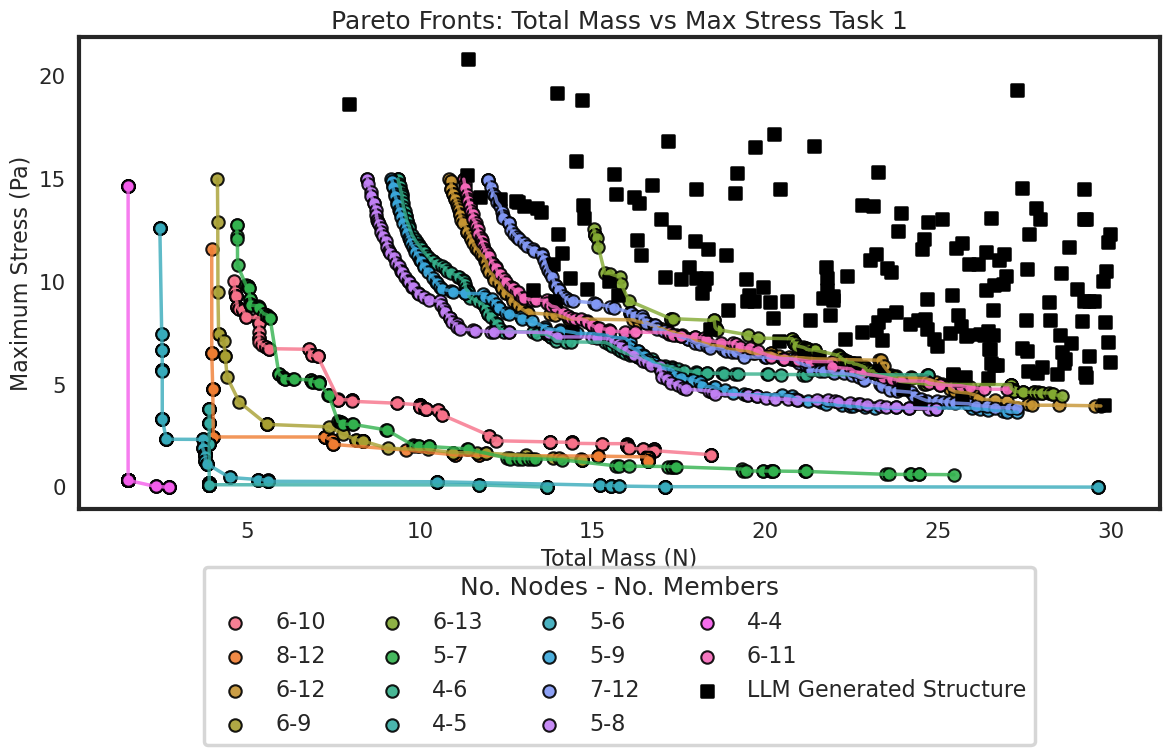

In [5]:
import glob2
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Collect all res files
res_files = glob2.glob("./benchs/*.pkl")

# Initialize
stress_list = []
mass_list = []
labels = []

# Set Seaborn style
sns.set_theme(style="white", font_scale=1.4)

# Collect data
for i in res_files:
    with open(i, "rb") as f:
        rr = pickle.load(f)
    try:
        stress_list.append(rr.F[:,0])  # max stress
        mass_list.append(rr.F[:,1])    # total mass
        
        # Extract label from filename (nodes-members)
        label = i.split("_")[-2] + "-" + i.split("_")[-1].replace(".pkl","")
        labels.append(label)
        
    except Exception as e:
        print("No Pareto front found in:", i)
        continue

# Now plot all in one figure
fig, ax = plt.subplots(figsize=(12,8))

colors = sns.color_palette("husl", len(stress_list))  # nicely separated colors

for idx, (stress, mass) in enumerate(zip(stress_list, mass_list)):
    
    # Sort by mass for smooth line
    sorted_idx = np.argsort(mass)
    mass_sorted = np.array(mass)[sorted_idx]
    stress_sorted = np.array(stress)[sorted_idx]
    
    # Scatter points using sns.scatterplot
    sns.scatterplot(
        x=mass_sorted,
        y=stress_sorted,
        s=80,
        edgecolor='black',
        linewidth=1.5,
        alpha=0.9,
        label=labels[idx],
        color=colors[idx],
        ax=ax
    )
    
    # Connect points with straight line
    ax.plot(
        mass_sorted,
        stress_sorted,
        color=colors[idx],
        linewidth=2.5,
        alpha=0.8
    )

df_q1_var1 = df_q1[df_q1["variation"] == 1]

# Overlay the LLM-generated structure points
sns.scatterplot(
    x=df_q1["best_total_mass"],
    y=df_q1["best_max_stress"],
    marker="s",
    s=75,
    color="black",
    edgecolor='black',
    linewidth=1.8,
    label="LLM Generated Structure",
    ax=ax
)

# Labeling and Titles
ax.set_xlabel('Total Mass (N)', fontsize=16)
ax.set_ylabel('Maximum Stress (Pa)', fontsize=16)
ax.set_title('Pareto Fronts: Total Mass vs Max Stress Task 1', fontsize=18)

# REMOVE grid
ax.grid(False)

# Legend BELOW the plot
# Note: 'ncol=2' makes 2 columns, adjust 'bbox_to_anchor' to move it below
leg = ax.legend(
    title="No. Nodes - No. Members",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),   # slightly lower for big font and frame
    frameon=True,
    ncol=4,                      # 4 columns
    fontsize=16,                 # big font for legend entries
    title_fontsize=18             # bigger title font
)

# Make the frame (legend box) thicker
leg.get_frame().set_linewidth(2.5)    # <- thicker frame

# Make plot borders thicker
for spine in ax.spines.values():
    spine.set_linewidth(3)   # or 3, depending how thick you want

plt.savefig("./figures/pareto_fronts_task1_var1.png", dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [6]:
import random

# First, group all node_dicts and member_dicts by (num_nodes, num_members)
temp_storage = {}

for idx, row in df_q1.iterrows():
    node_dict = row['best_node']
    member_dict = row['best_member']
    
    num_nodes = len(node_dict)
    num_members = len(member_dict)
    
    key = (num_nodes, num_members)
    
    if key not in temp_storage:
        temp_storage[key] = []
    
    temp_storage[key].append({
        'node_dict': node_dict,
        'member_dict': member_dict
    })

# Now randomly select ONE sample from each group
unique_node_member_dict = {}

for key, designs in temp_storage.items():
    selected = random.choice(designs)  # randomly pick one
    unique_node_member_dict[key] = selected

# Done!
print(f"Total unique (num_nodes, num_members) pairs: {len(unique_node_member_dict)}\n")

# Example: print the keys
for k in sorted(unique_node_member_dict.keys()):
    print(f"Nodes: {k[0]}, Members: {k[1]}")

unique_node_member_dict

Total unique (num_nodes, num_members) pairs: 15

Nodes: 4, Members: 4
Nodes: 4, Members: 5
Nodes: 4, Members: 6
Nodes: 5, Members: 6
Nodes: 5, Members: 7
Nodes: 5, Members: 8
Nodes: 5, Members: 9
Nodes: 5, Members: 10
Nodes: 6, Members: 9
Nodes: 6, Members: 10
Nodes: 6, Members: 11
Nodes: 6, Members: 12
Nodes: 6, Members: 13
Nodes: 7, Members: 12
Nodes: 8, Members: 12


{(4,
  6): {'node_dict': {'node_1': [0.0, 0.0],
   'node_2': [6.0, 0.0],
   'node_3': [2.0, 0.0],
   'node_4': [2.0, 2.5]}, 'member_dict': {'member_1': ['node_1',
    'node_2',
    '2'],
   'member_2': ['node_1', 'node_4', '2'],
   'member_3': ['node_2', 'node_4', '2'],
   'member_4': ['node_1', 'node_3', '4'],
   'member_5': ['node_3', 'node_4', '3'],
   'member_6': ['node_2', 'node_3', '2']}},
 (4,
  5): {'node_dict': {'node_1': [0.0, 0.0],
   'node_2': [6.0, 0.0],
   'node_3': [2.0, 0.0],
   'node_4': [2.0, 3.5]}, 'member_dict': {'member_1': ['node_1',
    'node_3',
    '2'],
   'member_2': ['node_2', 'node_3', '3'],
   'member_3': ['node_3', 'node_4', '2'],
   'member_4': ['node_4', 'node_1', '2'],
   'member_5': ['node_4', 'node_2', '3']}},
 (5,
  7): {'node_dict': {'node_1': [0.0, 0.0],
   'node_2': [6.0, 0.0],
   'node_3': [2.0, 0.0],
   'node_4': [2.0, 2.2],
   'node_5': [4.0, 2.2]}, 'member_dict': {'member_1': ['node_1',
    'node_3',
    '4'],
   'member_2': ['node_3', 'node_

In [7]:
def extract_solution(x, node_dict, fixed_nodes, area_id_keys, n_nodes):
    """
    Reconstruct full node_dict and member_dict from x vector
    """
    free_nodes = [k for k in sorted(node_dict.keys()) if k not in fixed_nodes]
    n_free = len(free_nodes)
    
    free_positions = x[:2*n_free]
    conn_area_vars = x[2*n_free:]
    
    # Rebuild node_dict
    new_node_dict = {}
    idx = 0
    for node in sorted(node_dict.keys()):
        if node in fixed_nodes:
            new_node_dict[node] = node_dict[node]
        else:
            new_node_dict[node] = [free_positions[idx], free_positions[idx+1]]
            idx += 2
    
    # Decode connections + area IDs
    connection_vec, area_vec = decode_connection_area_vec(conn_area_vars, n_nodes, len(area_id_keys))
    member_dict = vectors_to_member_dict_independent(connection_vec, area_vec, new_node_dict, area_id_keys)
    
    return new_node_dict, member_dict

In [8]:
def decode_connection_area_vec(x, n_nodes, n_areas):
    """
    Decodes a flat x vector into connection vector and area vector
    """
    n_members = len(x) // 3  # two for connection + one for area per member
    connection_vec = []
    area_vec = []
    for i in range(n_members):
        start_idx = int(np.clip(np.round(x[3*i + 0]), 0, n_nodes-1))
        end_idx = int(np.clip(np.round(x[3*i + 1]), 0, n_nodes-1))
        area_idx = int(np.clip(np.round(x[3*i + 2]), 0, n_areas-1))
        
        connection_vec.extend([start_idx, end_idx])
        area_vec.append(area_idx)
    
    return connection_vec, area_vec

from itertools import combinations
import random

# node_dict = {name: (x, y) for name, x, y in best_strcuture.nodes}


def member_dict_to_vectors(member_dict, area_id_keys):
    """
    Splits member dict into connection vector and area vector.
    Node indices are auto-generated from unique nodes present in member_dict.
    """
    # Collect unique nodes used
    unique_nodes = sorted({node for m in member_dict.values() for node in m[:2]})
    node_key_to_idx = {key: idx for idx, key in enumerate(unique_nodes)}
    area_key_to_idx = {str(key): idx for idx, key in enumerate(area_id_keys)}
    
    sorted_keys = sorted(member_dict.keys())
    connection_vec = []
    area_vec = []
    for key in sorted_keys:
        start_node, end_node, area_id = member_dict[key]
        connection_vec.append(node_key_to_idx[start_node])
        connection_vec.append(node_key_to_idx[end_node])
        area_vec.append(area_key_to_idx[str(area_id)])
    return connection_vec, area_vec, sorted_keys, unique_nodes


def vectors_to_member_dict_independent(connection_vec, area_vec, node_dict, area_id_keys):
    """
    Reconstructs member dict from connection vector and area vector using node_dict.
    Node names are inferred from sorted(node_dict.keys()) by index.
    """
    assert len(connection_vec) % 2 == 0, "Connection vector must have even number of elements (start,end pairs)"
    assert len(connection_vec) // 2 == len(area_vec), "Mismatch between connections and areas"
    
    node_keys = sorted(node_dict.keys())
    num_members = len(area_vec)
    member_dict = {}
    
    member_keys = [f"member_{i+1}" for i in range(num_members)]
    
    for i in range(num_members):
        start_idx = connection_vec[2*i]
        end_idx = connection_vec[2*i + 1]
        area_idx = area_vec[i]
        
        start_node = node_keys[start_idx]
        end_node = node_keys[end_idx]
        area_id = area_id_keys[area_idx]
        
        member_dict[member_keys[i]] = (start_node, end_node, str(area_id))
    
    return member_dict


def node_dict_to_vector(node_dict):
    """Flattens a node dict to a 1D list in consistent order."""
    sorted_keys = sorted(node_dict.keys())
    vec = []
    for key in sorted_keys:
        vec.extend(node_dict[key])
    return vec, sorted_keys  # return order for decoding later

def vector_to_node_dict(vec):
    """Reconstructs a node dict from a 1D vector by generating keys automatically."""
    assert len(vec) % 2 == 0, "Vector length must be even (pairs of x,y)"
    num_nodes = len(vec) // 2
    node_dict = {}
    for i in range(num_nodes):
        key = f"node_{i+1}"  # auto-generate keys like node_1, node_2, etc.
        node_dict[key] = [vec[2*i], vec[2*i + 1]]
    return node_dict

def objective_func(x, member_dict, load, supports):
    new_dict = vector_to_node_dict(x)
    t = make_truss(new_dict, member_dict, load, supports)
    max_stress = max(np.abs(np.array(list(t.member_stress().values()))))
    w,_ = t.structure_mass()
    return np.array([max_stress, w])

def contraint_func_mass(x, member_dict, load, supports, max_weight=30):
    new_dict = vector_to_node_dict(x)
    t = make_truss(new_dict, member_dict, load, supports)
    # max_stress = max(np.abs(np.array(list(t.member_stress().values()))))
    curr_weight,_ = t.structure_mass()
    return max_weight-curr_weight

def contraint_func_stress(x, member_dict, load, supports, max_stress=30):
    new_dict = vector_to_node_dict(x, ss)
    t = make_truss(new_dict, member_dict, load, supports)
    curr_stress = max(np.abs(np.array(list(t.member_stress().values()))))
    return max_stress-curr_stress
    
constraints = [
    {'type': 'ineq', 'fun': contraint_func_mass},
    {'type': 'ineq', 'fun': contraint_func_stress},
]

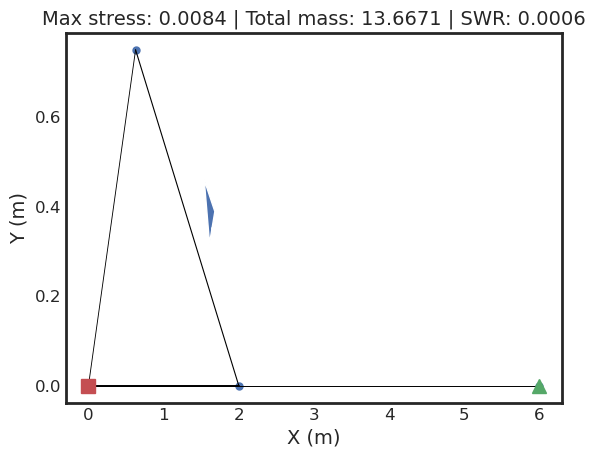

In [9]:
with open("./benchs/res_4_5.pkl", "rb") as f:
    rr = pickle.load(f)
x = rr.X[1]

nd =unique_node_member_dict[(4,4)]["node_dict"]
fixed_nodes = list(load.keys()) + list(supports.keys())

new_node_dict, new_member_dict = extract_solution(
        x, 
        nd, 
        fixed_nodes, 
        area_id_keys=list(area_id.keys()), 
        n_nodes=len(nd)
    )

t = make_truss(new_node_dict, new_member_dict, load, supports)
plot_truss(t)

In [10]:
node_dict

{'node_1': [0.0, 0.0],
 'node_2': [6.0, 0.0],
 'node_3': [2.0, 0.0],
 'node_4': [3.0, 3.1]}

In [11]:
new_member_dict

{'member_1': ('node_2', 'node_1', '2'),
 'member_2': ('node_2', 'node_3', '2'),
 'member_3': ('node_3', 'node_1', '3'),
 'member_4': ('node_3', 'node_4', '0'),
 'member_5': ('node_1', 'node_4', '2')}

In [12]:
nd

{'node_1': [0.0, 0.0],
 'node_2': [6.0, 0.0],
 'node_3': [2.0, 0.0],
 'node_4': [3.0, 3.5]}

In [13]:
node_dict_input

{'node_1': (0.0, 0.0), 'node_2': (6.0, 0.0), 'node_3': (2.0, 0.0)}